Import library

In [1]:
import numpy as np
import os
import shutil
import random as rn
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Load Dataset

In [2]:
IMAGE_SIZE = 264
IMAGE_SIZE = 264
BATCH_SIZE = 16
Channels = 3
epochs = 30

In [3]:
dataset =tf.keras.preprocessing.image_dataset_from_directory(
    "Blood cell Cancer [ALL]",
    shuffle = True,
    image_size =(IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE

)

Found 3242 files belonging to 4 classes.


In [4]:
class_names = dataset.class_names
class_names

['Benign', '[Malignant] Pre-B', '[Malignant] Pro-B', '[Malignant] early Pre-B']

In [5]:
len(dataset)

203

In [6]:

for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].shape)


(264, 264, 3)


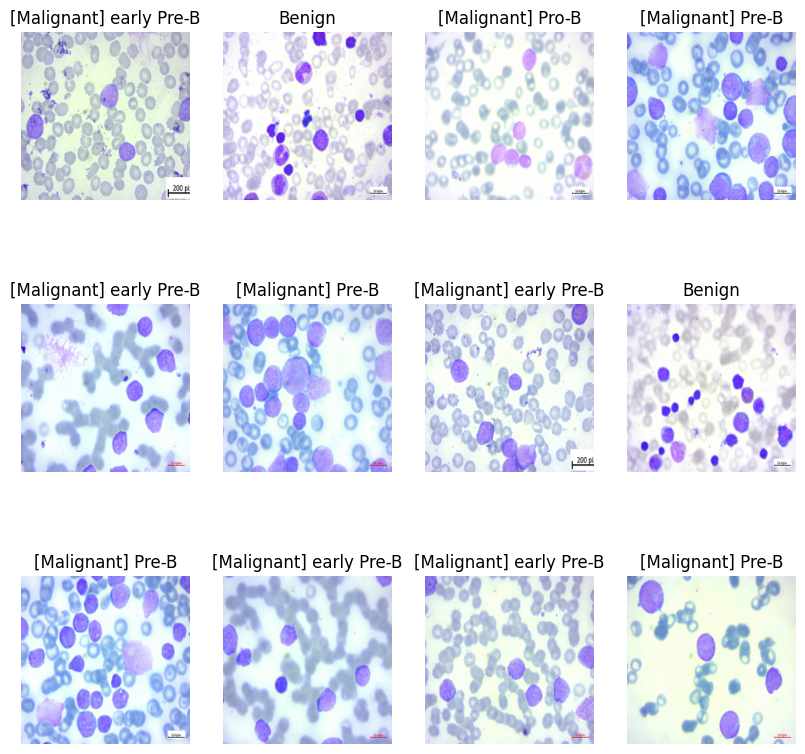

In [7]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
                 ax=plt.subplot(3,4,i+1)     
    
                 plt.imshow(image_batch[i].numpy().astype("uint8"))
                 plt.title(class_names[label_batch[i]])
                 plt.axis("off")
                  
                 
             

Spliting_Dataset

In [8]:
len(dataset)

203

In [9]:
#80% ==> training 
# 20% ==> 10% validation , 10% test

In [10]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
      ds=ds.shuffle(shuffle_size,seed=12)
      train_size = int(train_split*ds_size)
      val_size = int(val_split*ds_size)

      train_ds= ds.take(train_size)
      val_ds = ds.skip(train_size).take(val_size)
      test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds,test_ds

In [11]:
train_ds, val_ds,test_ds =get_dataset_partitions_tf(dataset)


In [12]:
len(train_ds)


162

In [13]:
len(test_ds)

21

In [14]:
len(val_ds)

20

# Data preprocessing

In [15]:
train_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds= test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds= val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
    ])

In [17]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
    ])

# CNN Model

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint
model_filepath = "Blood cell Cancer [ALL]"
checkpoint = ModelCheckpoint(
    filepath=model_filepath,
    monitor ='val_accuracy',
    mode ='max',
    save_best_only=True,
    verbose=2
  
)

In [19]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, Channels)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'), 
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'), 
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'), 
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'), 
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation = 'relu'),
    layers.Dense(n_classes,activation = 'softmax')
])

model.build(input_shape = input_shape)

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (16, 264, 264, 3)         0         
                                                                 
 sequential_1 (Sequential)   (16, 264, 264, 3)         0         
                                                                 
 conv2d (Conv2D)             (16, 262, 262, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (16, 131, 131, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (16, 129, 129, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (16, 64, 64, 64)         0         
 2D)                                                  

In [21]:

model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])


In [22]:
history = model.fit( 
    train_ds, 
    epochs= 50,
    batch_size = BATCH_SIZE,
    validation_data = val_ds,
    verbose = 1
       )
 

Epoch 1/50


162/162 [==============================] - 154s 603ms/step - loss: 1.3288 - accuracy: 0.6856 - val_loss: 0.3288 - val_accuracy: 0.8594
Epoch 2/50
162/162 [==============================] - 78s 480ms/step - loss: 0.4375 - accuracy: 0.8372 - val_loss: 0.3110 - val_accuracy: 0.8844
Epoch 3/50
162/162 [==============================] - 76s 470ms/step - loss: 0.3732 - accuracy: 0.8573 - val_loss: 0.4262 - val_accuracy: 0.8469
Epoch 4/50
162/162 [==============================] - 77s 473ms/step - loss: 0.3432 - accuracy: 0.8697 - val_loss: 0.3189 - val_accuracy: 0.8781
Epoch 5/50
162/162 [==============================] - 76s 470ms/step - loss: 0.2834 - accuracy: 0.8929 - val_loss: 0.3578 - val_accuracy: 0.8844
Epoch 6/50
162/162 [==============================] - 77s 476ms/step - loss: 0.2746 - accuracy: 0.9014 - val_loss: 0.3161 - val_accuracy: 0.9031
Epoch 7/50
162/162 [==============================] - 76s 472ms/step - loss: 0.2619 - accuracy: 0.9041 - val_loss: 0.2962 - val_accuracy: 0.

In [23]:
scores = model.evaluate(test_ds)

21/21 [==============================] - 33s 97ms/step - loss: 0.0806 - accuracy: 0.9821


In [24]:
scores

[0.08058054745197296, 0.9821428656578064]

In [25]:
history

In [26]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 162}

In [27]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss= history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

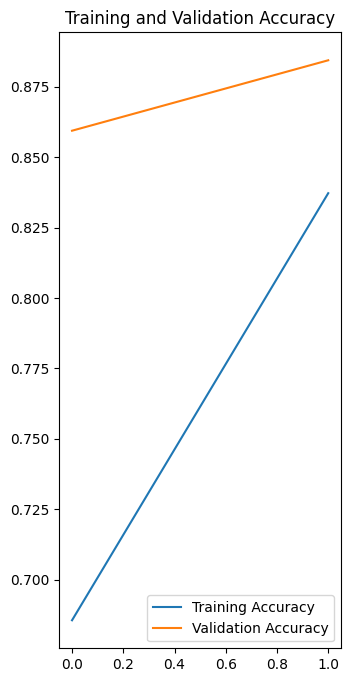

In [29]:

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(epochs)[:2],acc[:2],label='Training Accuracy')
plt.plot(range(epochs)[:2],val_acc[:2],label='Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

Text(0.5, 1.0, 'Training and Validation loss')

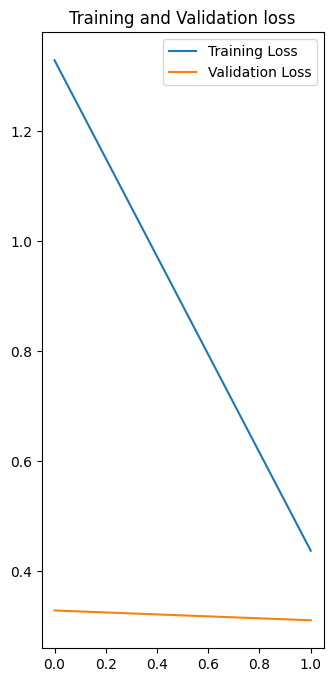

In [30]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(epochs)[:2],loss[:2],label='Training Loss')
plt.plot(range(epochs)[:2],val_loss[:2],label='Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation loss')

First Image to predict
First image's actual label: [Malignant] Pro-B
1/1 [==============================] - 0s 293ms/step
predicted label: [Malignant] Pro-B


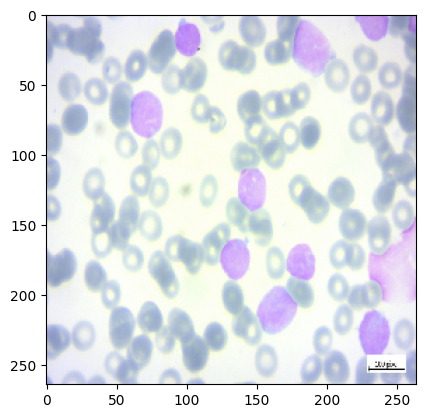

In [31]:
for image_batch,label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()

    print("First Image to predict")
    plt.imshow(first_image)
    print("First image's actual label:",class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])]);

In [32]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0) #create a batch

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 28ms/step


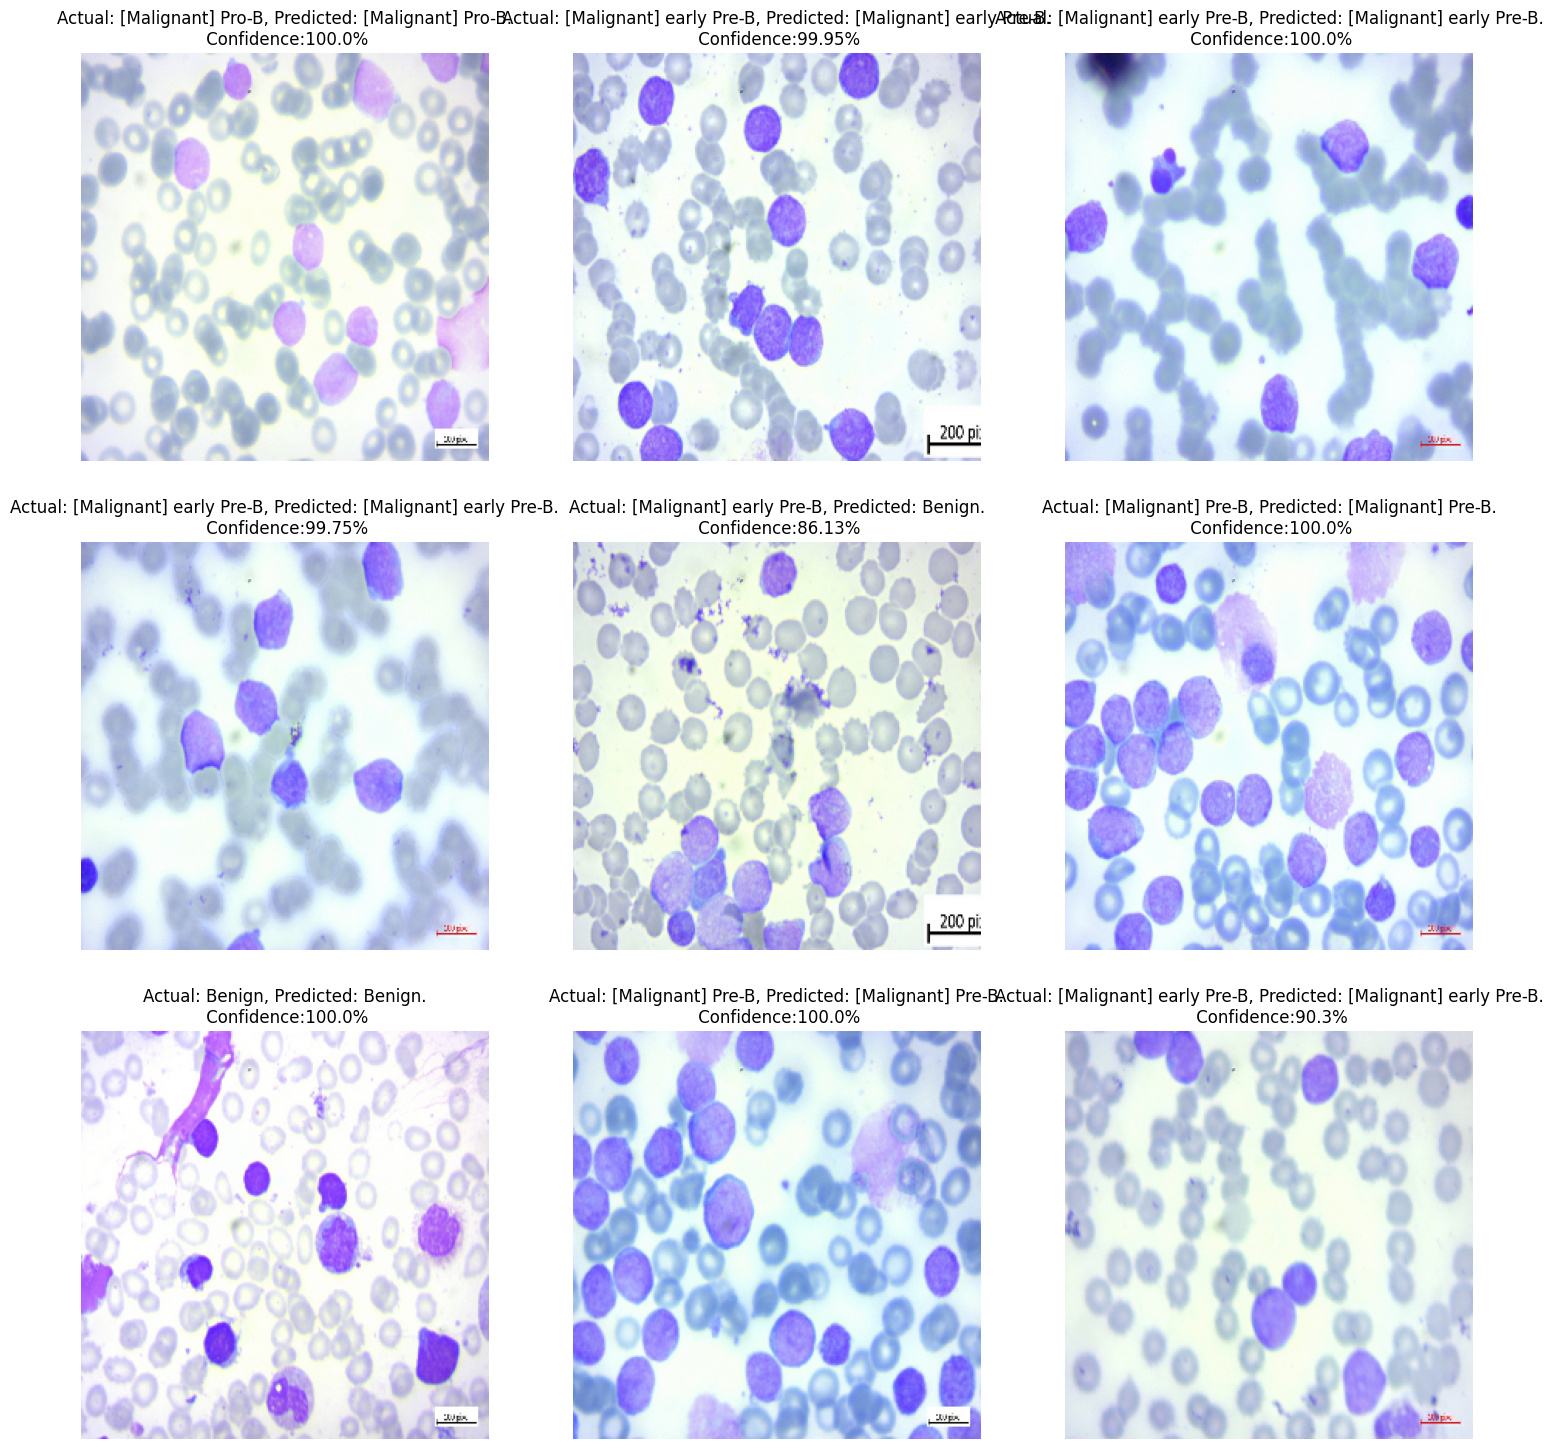

In [33]:
plt.figure(figsize=(18,18))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, Predicted: {predicted_class}.\n Confidence:{confidence}%")

        plt.axis("off")

#confusion Matrix for CNN

In [34]:
y_pred = model.predict(test_ds)


21/21 [==============================] - 2s 97ms/step


In [35]:
y_pred_labels = np.argmax(y_pred, axis=1)


In [36]:
y_true_labels = np.concatenate([y for x, y in test_ds], axis=0)


In [37]:
from sklearn.metrics import confusion_matrix

confusion_mat = confusion_matrix(y_true_labels, y_pred_labels)


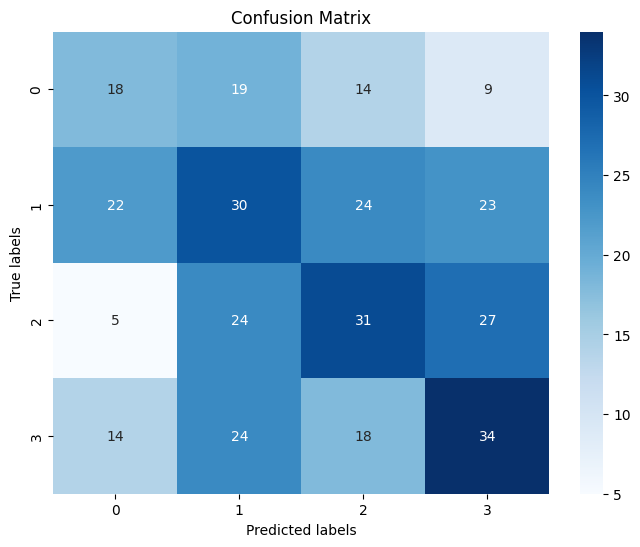

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [39]:
model_version = 1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets


# Res NET model

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Add, Input
from tensorflow.keras import Model

def resnet(input_shape, n_classes=4):
    inputs = Input(shape=input_shape)

    # First Convolutional Block
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)

    # Residual Blocks
    residual = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    residual = Conv2D(64, (3, 3), activation='relu', padding='same')(residual)
    x = Conv2D(64, (1, 1), activation='relu', padding='same')(x)  # Add 1x1 convolution to match shapes
    x = Add()([x, residual])
    x = MaxPooling2D((2, 2))(x)

    residual = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    residual = Conv2D(128, (3, 3), activation='relu', padding='same')(residual)
    x = Conv2D(128, (1, 1), activation='relu', padding='same')(x)  # Add 1x1 convolution to match shapes
    x = Add()([x, residual])
    x = MaxPooling2D((2, 2))(x)

    # Flatten and Dense Layers
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.25)(x)
    outputs = Dense(n_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model



In [41]:
model = resnet((264, 264, 3), 4)

In [42]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 264, 264, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 264, 264, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_5 (MaxPooling2D)  (None, 132, 132, 32  0          ['conv2d_5[0][0]']               
                                )                                                             

In [43]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [45]:
history = model.fit(
        train_ds, 
        epochs=50, 
        batch_size=BATCH_SIZE,
        validation_data=val_ds, 
        verbose=1)

Epoch 1/50
162/162 [==============================] - 181s 1s/step - loss: 1.3592 - accuracy: 0.3090 - val_loss: 1.3599 - val_accuracy: 0.3000
Epoch 2/50
162/162 [==============================] - 180s 1s/step - loss: 1.3587 - accuracy: 0.3090 - val_loss: 1.3597 - val_accuracy: 0.3000
Epoch 3/50
162/162 [==============================] - 180s 1s/step - loss: 1.3585 - accuracy: 0.3090 - val_loss: 1.3595 - val_accuracy: 0.3000
Epoch 4/50
162/162 [==============================] - 180s 1s/step - loss: 1.3583 - accuracy: 0.3090 - val_loss: 1.3594 - val_accuracy: 0.3000
Epoch 5/50
162/162 [==============================] - 180s 1s/step - loss: 1.3582 - accuracy: 0.3090 - val_loss: 1.3593 - val_accuracy: 0.3000
Epoch 6/50
162/162 [==============================] - 180s 1s/step - loss: 1.3582 - accuracy: 0.3090 - val_loss: 1.3593 - val_accuracy: 0.3000
Epoch 7/50
162/162 [==============================] - 180s 1s/step - loss: 1.3581 - accuracy: 0.3090 - val_loss: 1.3593 - val_accuracy: 0.3000

KeyboardInterrupt: 

In [31]:
scores = model.evaluate(test_ds)

21/21 [==============================] - 8s 93ms/step - loss: 0.2368 - accuracy: 0.9554


In [32]:
scores

[0.23676429688930511, 0.9553571343421936]

In [33]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 162}

In [34]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss= history.history['loss']
val_loss = history.history['val_loss']


Text(0.5, 1.0, 'Training and Validation Accuracy')

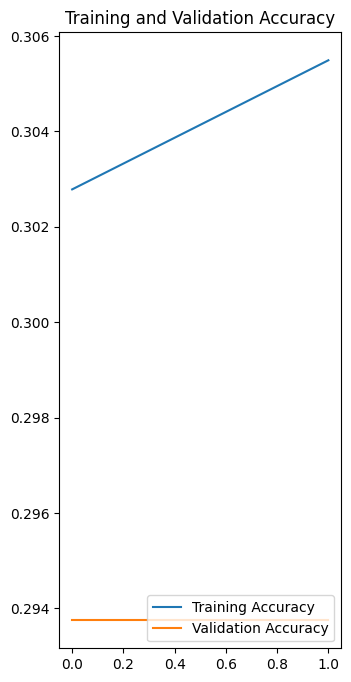

In [36]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(epochs)[:2],acc[:2],label='Training Accuracy')
plt.plot(range(epochs)[:2],val_acc[:2],label='Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

Text(0.5, 1.0, 'Training and Validation loss')

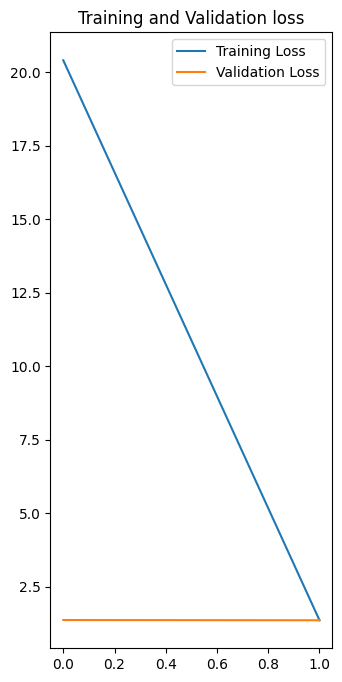

In [37]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(epochs)[:2],loss[:2],label='Training Loss')
plt.plot(range(epochs)[:2],val_loss[:2],label='Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation loss')

First Image to predict
First image's actual label: [Malignant] Pro-B
1/1 [==============================] - 0s 220ms/step
predicted label: [Malignant] Pro-B


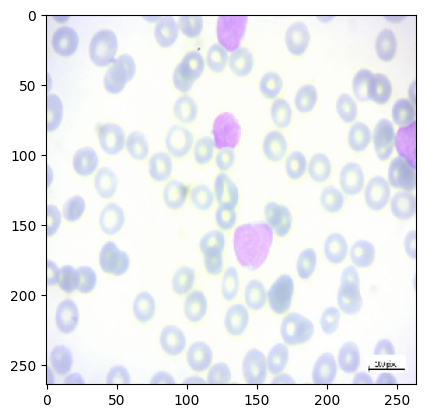

In [38]:
for image_batch,label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()

    print("First Image to predict")
    plt.imshow(first_image)
    print("First image's actual label:",class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])]);

In [39]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0) #create a batch

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 26ms/step


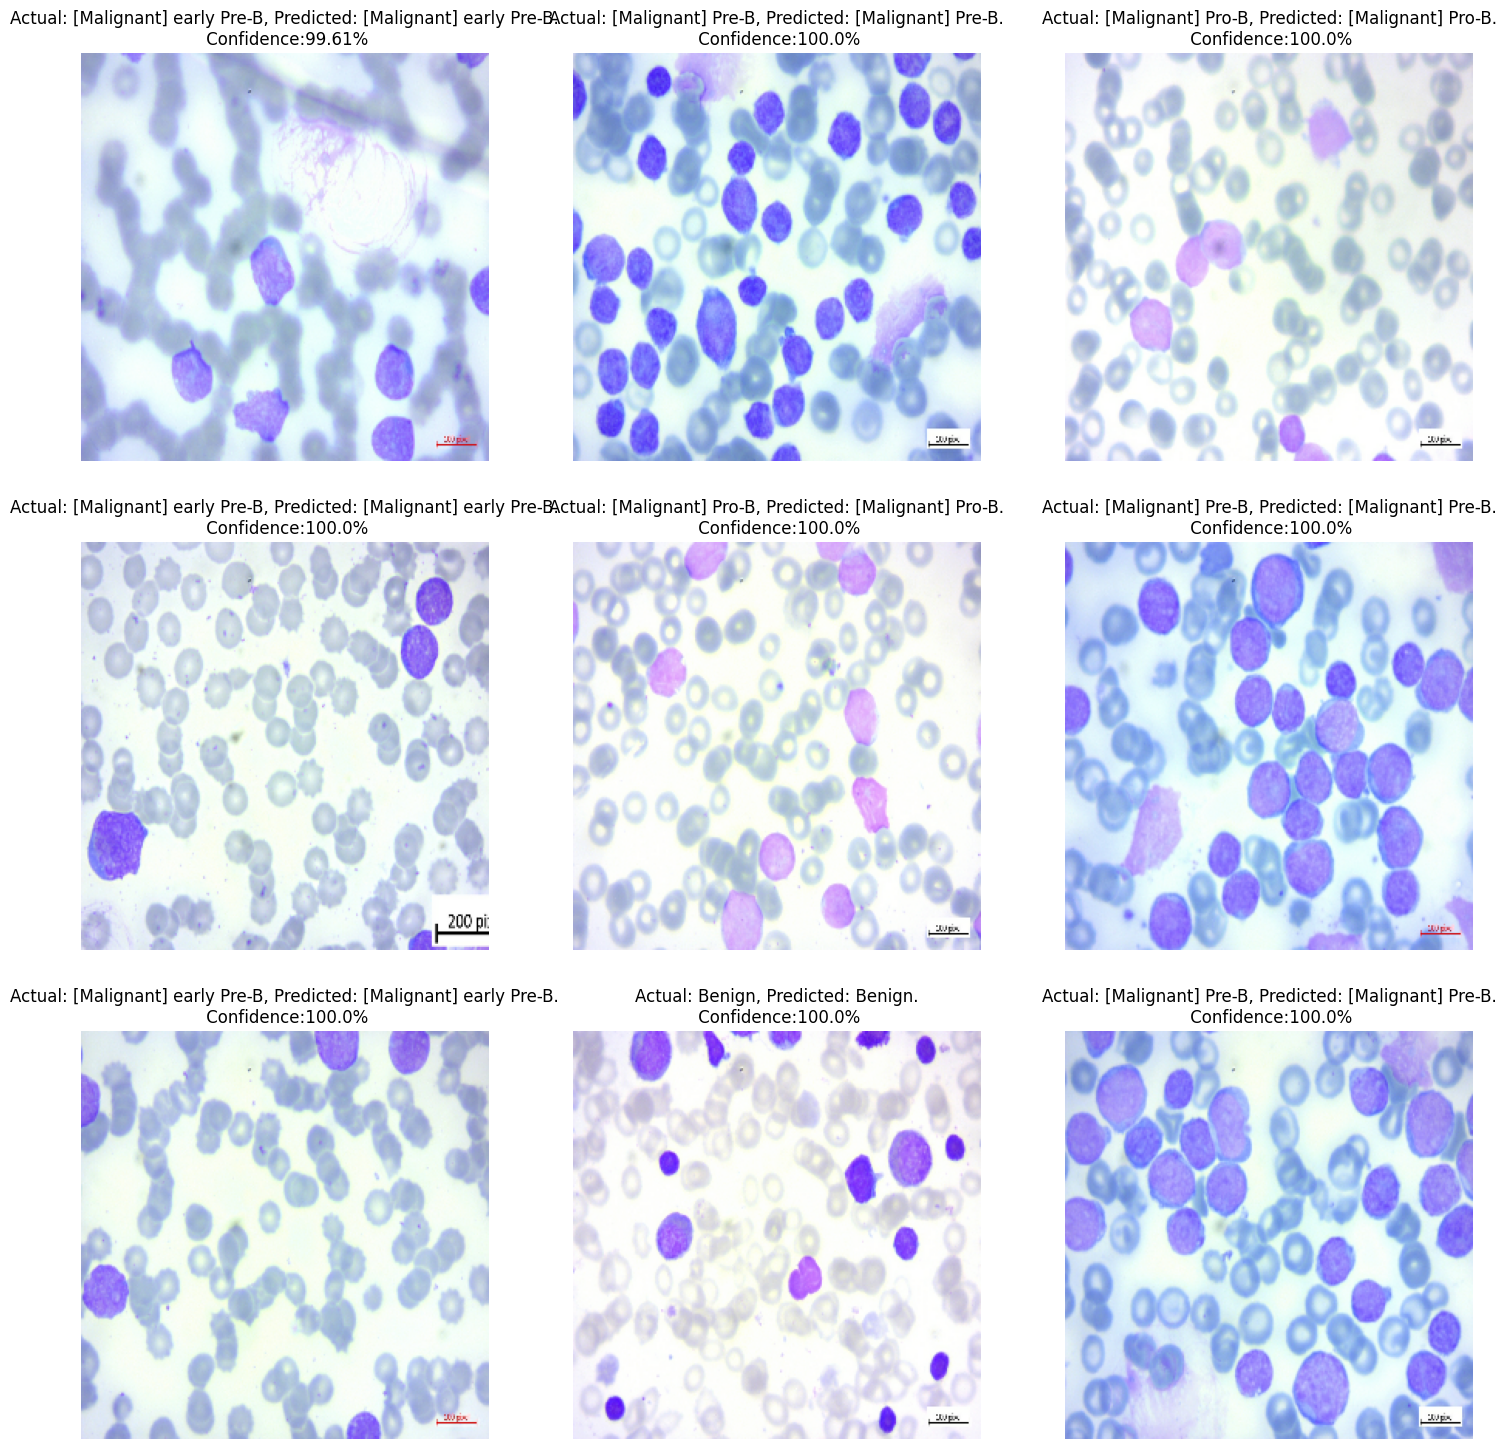

In [40]:
plt.figure(figsize=(18,18))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, Predicted: {predicted_class}.\n Confidence:{confidence}%")

        plt.axis("off")

In [41]:
model_version = 2
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/2\assets


INFO:tensorflow:Assets written to: ../models/2\assets


In [27]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
